In [1]:
import collections
import logging
import pathlib
import time
import warnings
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import requests
from tqdm.auto import tqdm
import redo
import requests_cache
import pypdb
import biotite.database.rcsb as rcsb
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import py3Dmol

from opencadd.structure.superposition.api import align, METHODS
from opencadd.structure.core import Structure


# Define paths
HERE = pathlib.Path(_dh[-1])
DATA = HERE / "data"

pairs = collections.OrderedDict([('7VH8','7DI'),
             ('6XHO', 'V34'),
             ('6XHN', 'V3D'),
             ('6XHM', 'V2M'),
             ('6WNP', 'U5G')])

pairs_smiles = collections.OrderedDict([('7VH8','CC1([C@@H]2[C@H]1[C@H](N(C2)C(=O)[C@H](C(C)(C)C)NC(=O)C(F)(F)F)C(=O)N[C@@H](C[C@@H]3CCNC3=O)C#N)C'),
             ('6XHO', 'CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](CC(C)C)NC(=O)C2=CC3=C(N2)C=CC=C3OC'),
             ('6XHN', 'CC(C)C[C@@H](C(=O)N[C@@H](C[C@@H]1CCNC1=O)C(=O)C)NC(=O)C2=CC3=C(N2)C=CC=C3OC'),
             ('6XHM', 'CC(C)C[C@@H](C(=O)N[C@@H](C[C@@H]1CCNC1=O)C(=O)CO)NC(=O)C2=CC3=C(N2)C=CC=C3OC'),
             ('6WNP', 'CC1([C@@H]2[C@H]1[C@H](N(C2)C(=O)[C@H](C(C)(C)C)NC(=O)NC(C)(C)C)C(=O)N[C@@H](CC3CCC3)[C@H](C(=O)N)O)C')])



# Download PDBs

In [ ]:
#download PDBs
structures = [Structure.from_pdbid(pdb_id) for pdb_id in pairs]

#extract protein ligand complex
complexes = [
    Structure.from_atomgroup(structure.select_atoms(f"protein or resname {ligand}"))
    for structure, ligand in zip(structures, pairs.values())
]

#write to file
for complex_, pdb_id in zip(complexes, pairs.keys()):
    complex_.write(DATA / f"{pdb_id}.pdb")
    
#align proteins
results = align(complexes, method=METHODS["mda"])

aligned_pdbs= []
for complex_, pdb_id in zip(complexes, pairs.keys()):
    complex_.write(DATA / f"{pdb_id}_aligned.pdb")
    aligned_pdbs.append(DATA / f"{pdb_id}_aligned.pdb")


# Align and visualize PDBs 

In [ ]:
view = py3Dmol.view(width=400, height=300)
for pdb in aligned_pdbs:
    print(pdb)
    view.addModel(open(pdb, 'r').read(),'pdb')

#view.addModelsAsFrames(all_proteins)
view.setStyle({'model': -1}, {"cartoon": {'color': 'purple'}})
view.setStyle({'model': 0}, {"cartoon": {'color': 'yellow'}})
view.setStyle({'model': 1}, {"cartoon": {'color': 'blue'}})
view.setStyle({'model': 2}, {"cartoon": {'color': 'red'}})
view.setStyle({'model': 3}, {"cartoon": {'color': 'orange'}})
view.setStyle({'model': 4}, {"cartoon": {'color': 'green'}})
view.zoomTo()
view.show()

# Visualize and save aligned ligands

In [4]:
ligands = [
    Structure.from_atomgroup(complex_.select_atoms(f"resname {ligand}"))
    for complex_, ligand in zip(complexes, pairs.values())
]
ligand_pdbs = []
for ligand, pdb_id in zip(ligands, pairs.keys()):
    ligand.write(DATA / f"{pdb_id}_lig.pdb")
    ligand_pdbs.append(DATA / f"{pdb_id}_lig.pdb")
                       
#remove chain B ligands and H atoms
for pdb in ligand_pdbs:
    infile = open(pdb)
    text = ""
    for line in infile:
        if line[len(line)-10:len(line)].strip() != "B" and "H" not in line:
            text += line
    infile.close()
    outfile = open(pdb, 'w')
    for line in text:
        outfile.write(line)
    outfile.close()
    
view = py3Dmol.view(width=400, height=300)
for pdb in ligand_pdbs:
    view.addModel(open(pdb, 'r').read(),'pdb')

#view.addModelsAsFrames(all_proteins)
view.setStyle({'model': -1}, {"stick": {'color': 'purple'}})
view.setStyle({'model': 0}, {"stick": {'color': 'yellow'}})
view.setStyle({'model': 1}, {"stick": {'color': 'blue'}})
view.setStyle({'model': 2}, {"stick": {'color': 'red'}})
view.setStyle({'model': 3}, {"stick": {'color': 'orange'}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Put ligands into RDkit representation

CC(C)(C)C(NC(O)C(F)(F)F)C(O)N1CC2C(C1C(O)NC(CN)CC1CCNC1O)C2(C)C
CCOC(O)CCC(CC1CCNC1O)NC(O)C(CC(C)C)NC(O)C1CC2C(CCCC2OC)N1
COC1CCCC2NC(C(O)NC(CC(C)C)C(O)NC(CC3CCNC3O)C(C)O)CC21
COC1CCCC2NC(C(O)NC(CC(C)C)C(O)NC(CC3CCNC3O)C(O)CO)CC21
CC(C)(C)NC(O)NC(C(O)N1CC2C(C1C(O)NC(CC1CCC1)C(O)C(N)O)C2(C)C)C(C)(C)C
Number of molecules: 5


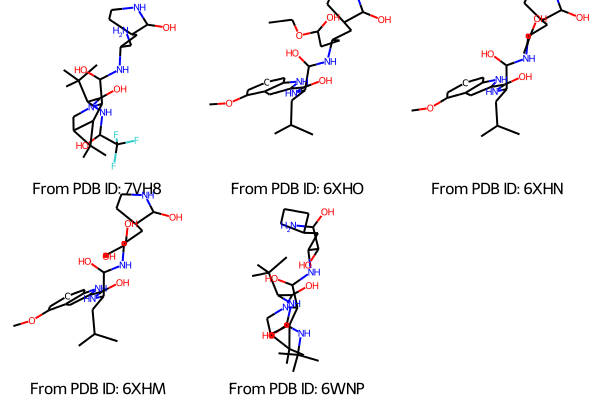

In [5]:
#put ligands into Rdkit representation
from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import (
    ChemicalFeatures,
    rdDistGeom,
    Draw,
    rdMolTransforms,
    AllChem,
)
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib

molecules = []
for mol_file in ligand_pdbs:
    molecule = Chem.MolFromPDBFile(str(mol_file), removeHs=False)
    if molecule is None:
        print(mol_file, "Could not be read")
    else:
        Chem.SanitizeMol(molecule)
        print(Chem.MolToSmiles(molecule))
        molecules.append(molecule)
print(f"Number of molecules: {len(molecules)}")
pdb_ids = [pdb_id for pdb_id in pairs]
im = Draw.MolsToGridImage(
    molecules,
    molsPerRow=3,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)
display(im)

# Fix RDKit Molecules

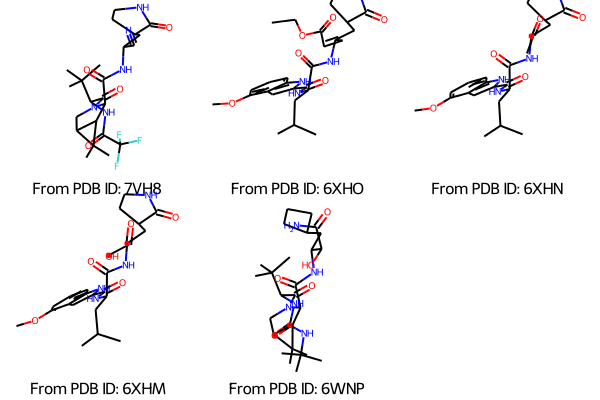

In [6]:
#pdb, smiles dictionary
ligand_smiles = [pairs_smiles[pdb_id] for pdb_id in pairs_smiles]

# Generate RDKit Mol object from SMILES
reference_molecules = [Chem.MolFromSmiles(smiles) for smiles in ligand_smiles]


# Assign bond orders to molecules based on SMILES patterns of reference molecules
molecules = [
    AllChem.AssignBondOrdersFromTemplate(reference_molecule, molecule)
    for reference_molecule, molecule in zip(reference_molecules, molecules)
]

im = Draw.MolsToGridImage(
    molecules,
    molsPerRow=3,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)
display(im)

# Visualize Molecules in 2D

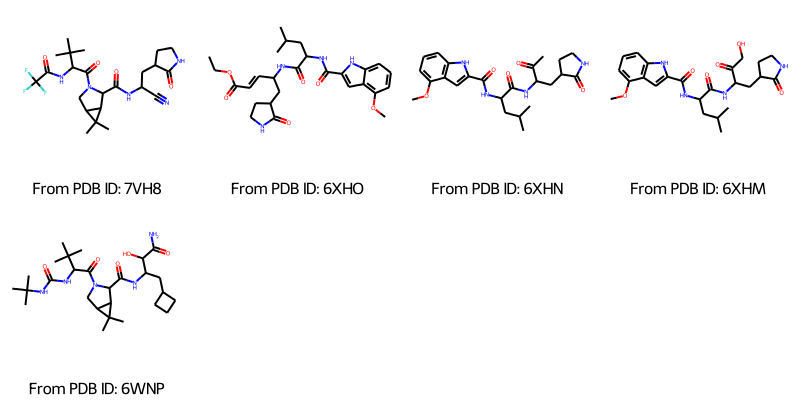

In [7]:
molecules_2d = []
for molecule in molecules:
    tmp = Chem.Mol(molecule)
    AllChem.Compute2DCoords(tmp)
    molecules_2d.append(tmp)
Draw.MolsToGridImage(
    molecules_2d,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

# Find Pharmacophore Features

In [8]:
import os

fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
feature_factory = AllChem.BuildFeatureFactory(fdefName)

molecule_feature_frequencies = []
for molecule in molecules:
    features = [feature.GetFamily() for feature in feature_factory.GetFeaturesForMol(molecule)]
    feature_frequency = collections.Counter(features)
    molecule_feature_frequencies.append(feature_frequency)

feature_frequencies_df = (
    pd.DataFrame(
        molecule_feature_frequencies,
        index=[f"Mol{i}" for i, _ in enumerate(molecules, 1)],
    )
    .fillna(0)
    .astype(int)
)
feature_frequencies_df.transpose()

,Mol1,Mol2,Mol3,Mol4,Mol5
Donor,4,4,4,5,6
Acceptor,4,6,5,6,5
Hydrophobe,6,7,5,5,6
LumpedHydrophobe,2,2,2,2,4
Aromatic,0,2,2,2,0


# Visualize Features

In [9]:
def visualize_features(
    molecules,
    features,
    feature_type="features",
    color="yellow",
    sphere_radius=0.5,
):
    """Generate a view of the molecules highlighting the specified feature type.

    """
    print(f"Number of {feature_type} in all ligands: {sum([len(i) for i in features])}")
    viewer = py3Dmol.view(width=400, height=300)
    for mol in molecules:
        mblock = Chem.MolToMolBlock(mol)
        viewer.addModel(mblock, 'mol')
    viewer.setStyle({"stick":{}})
    for i, feature_set in enumerate(features, 1):
        for feature in feature_set:
            loc = list(feature.GetPos())
            label = f"{feature_type}_{i}"
            atom_ids = feature.GetAtomIds()
            viewer.addStyle({'model': i-1, 'serial': atom_ids[0]}, {"sphere": {'color': color, 'radius': sphere_radius}})
    return viewer

In [10]:
acceptors = []
donors = []
hydrophobics = []

for molecule in molecules:
    acceptors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Acceptor"))
    donors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Donor"))
    hydrophobics.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Hydrophobe"))

features = {
    "donors": donors,
    "acceptors": acceptors,
    "hydrophobics": hydrophobics,
}

feature_colors = {
    "donors": "green",  # Green
    "acceptors": "red",  # Red
    "hydrophobics": "yellow",  # Yellow
}
feature_type = "donors"
viewer = visualize_features(
    molecules,
    features[feature_type],
    feature_type=feature_type,
    color=feature_colors[feature_type],
    sphere_radius=0.5,
)
viewer.zoomTo()
viewer.show()

Number of donors in all ligands: 23


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
feature_type = "acceptors"
viewer = visualize_features(
    molecules,
    features[feature_type],
    feature_type=feature_type,
    color=feature_colors[feature_type],
    sphere_radius=0.5,
)
viewer.zoomTo()
viewer.show()

Number of acceptors in all ligands: 26


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [12]:
feature_type = "hydrophobics"
viewer = visualize_features(
    molecules,
    features[feature_type],
    feature_type=feature_type,
    color=feature_colors[feature_type],
    sphere_radius=0.5,
)
viewer.zoomTo()
viewer.show()

Number of hydrophobics in all ligands: 29


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol